<a href="https://colab.research.google.com/github/NassarX/Brain-Tumor-MRI-Classifier/blob/main/BrainTumor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Colab Section

Please ignore that section if you're working locally!

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#### Clone Repo

In [ ]:
# Clone repo and navigate to root directory
!git clone https://github.com/NassarX/Brain-Tumor-MRI-Classifier.git '/content/drive/MyDrive/Colab Notebooks/Brain-Tumor-MRI-Classifier'

#### Kaggle credentials

Upload your Kaggle API credentials file (usually named kaggle.json) to the Colab environment.

In [ ]:
from google.colab import files
files.upload()

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/Colab Notebooks'
!mv kaggle.json /content/drive/MyDrive/Colab\ Notebooks/

#### Navigate to project path

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/Brain-Tumor-MRI-Classifier

**Make sure to pull latest updates each time and after pushing any changes as Colab not saving history !**

In [ ]:
!git pull origin main

# Import required libraries

Here are the libraries and packages that we will be using:

In [1]:
# System
import os
import sys
import configparser
import time
from math import ceil

# Reading and setup data
import cv2
import imutils
from tqdm import tqdm

# Loading datasets
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# Modeling
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras import layers
from keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications.efficientnet import EfficientNetB1
from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, Activation, BatchNormalization


# Evaluation
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix as cm, classification_report as cr

Import and append our custom modules

In [2]:
%reload_ext autoreload
%autoreload 2
module_path = os.path.abspath(os.path.join('./utils'))
if module_path not in sys.path:
    sys.path.append(module_path)

from utils.preprocess import *
from utils.helpers import *

### Load configs

Load the config file to dataset paths.

In [3]:
# Load the config file
config = configparser.ConfigParser()
config.read('config.ini')

# data
dataset_url = config.get('data', 'dataset_url')
downloads_path = config.get('data', 'downloads_path')
dataset_path = config.get('data', 'dataset_path')
original_dataset = config.get('data', 'original_dataset')
processed_dataset = config.get('data', 'processed_dataset')
augmented_dataset = config.get('data', 'augmented_dataset')
train_dataset = config.get('data', 'training_dataset')
test_dataset = config.get('data', 'testing_dataset')

# training
models_path = config.get('training', 'models_path')
img_size = int(config.get('training', 'img_size'))
batch_size = int(config.get('training', 'batch_size'))

# Data Preparation

In this step of data preparation we're going to download dataset, unzip and the to crop and extract image contour.

### Download dataset

Download the dataset from Kaggle into the `downloads` directory and unzip it.

The data set in the folder `downloads/brain-tumor-mri-dataset` which we will be using in our project. Inside the folder there are Testing and Training folders, each of which has 4 sub-folders containing 4 different classes of tumors.

**Note: make sure to have your Kaggle API credentials set up beforehand**

In [4]:
setup_dataset(dataset_url, downloads_path)

[1] Downloading dataset...
	Starting download process
brain-tumor-mri-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
[2] Unzipping dataset...
	Extracting files of downloads/brain-tumor-mri-dataset.zip


Extracting Images: 100%|██████████| 7023/7023 [00:01<00:00, 5326.35it/s]

	Done with downloads/brain-tumor-mri-dataset.zip
Dataset downloaded and unzipped successfully.


### Extract images

In order to crop the part that contains only the brain of the image, We used a cropping technique to find the extreme top, bottom, left and right points of the brain. You can read more about it here [Finding extreme points in contours with OpenCV](https://www.pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/).

The following function __`extract_images`__ for every image in downloads folder (original images) does the following:

- Read the image.
- Crop the part of the image representing only the brain.
- Save cropped images under new location `Dataset` .

In [5]:
extract_images(downloads_path, 'dataset')

Extracting images...


Processing . images:   0%|          | 0/2 [00:00<?, ?it/s]
Processing brain-tumor-mri-dataset/Training/pituitary images: 100%|██████████| 1457/1457 [00:02<00:00, 539.15it/s]
Processing brain-tumor-mri-dataset/Training/notumor images: 100%|██████████| 1595/1595 [00:01<00:00, 890.22it/s]
Processing brain-tumor-mri-dataset/Training/glioma images: 100%|██████████| 1321/1321 [00:02<00:00, 633.98it/s]
Processing brain-tumor-mri-dataset/Training/meningioma images: 100%|██████████| 1339/1339 [00:02<00:00, 613.57it/s]
Processing brain-tumor-mri-dataset/Testing/pituitary images: 100%|██████████| 300/300 [00:00<00:00, 539.74it/s]
Processing brain-tumor-mri-dataset/Testing/notumor images: 100%|██████████| 405/405 [00:00<00:00, 1152.19it/s]
Processing brain-tumor-mri-dataset/Testing/glioma images: 100%|██████████| 300/300 [00:00<00:00, 624.37it/s]
Processing brain-tumor-mri-dataset/Testing/meningioma images: 100%|██████████| 306/306 [00:00<00:00, 673.63it/s]

Images cropped successfully.


In order to better understand what it's doing, let's grab an image from the dataset and apply this cropping function to see the result:

### Plot Sample (Original | Cropped)

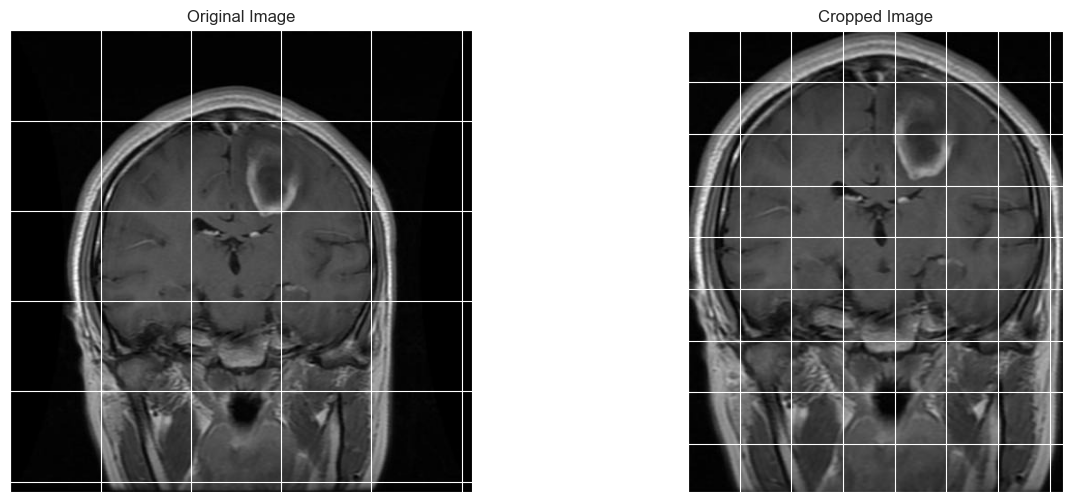

In [6]:
sample = cv2.imread(os.path.join(original_dataset, train_dataset, 'glioma', 'Tr-gl_0100.jpg'))
cropped_sample = extract_contour(sample)

# Exploratory Data Analysis

In [7]:
labels = ['pituitary', 'notumor', 'glioma', 'meningioma']

In [8]:
# Check the number of images in each class in the training dataset
files_path_dict = {}
num_images_per_label = []
label_names = []
num_testing_images = {}
for label in labels:
    train_path = os.path.join(dataset_path, train_dataset, label)
    test_path = os.path.join(dataset_path, test_dataset, label)
    files_path_dict[label] = [os.path.join(train_path, x) for x in os.listdir(train_path)]
    num_testing_images[label] = len([os.path.join(test_path, x) for x in os.listdir(test_path)])
    num_images_per_label.append(len(files_path_dict[label]))
    label_names.append(label)
    print('Number of images in {}: {}'.format(label, len(files_path_dict[label])))

Number of images in pituitary: 1457
Number of images in notumor: 1595
Number of images in glioma: 1321
Number of images in meningioma: 1339


### Visualize data distribution

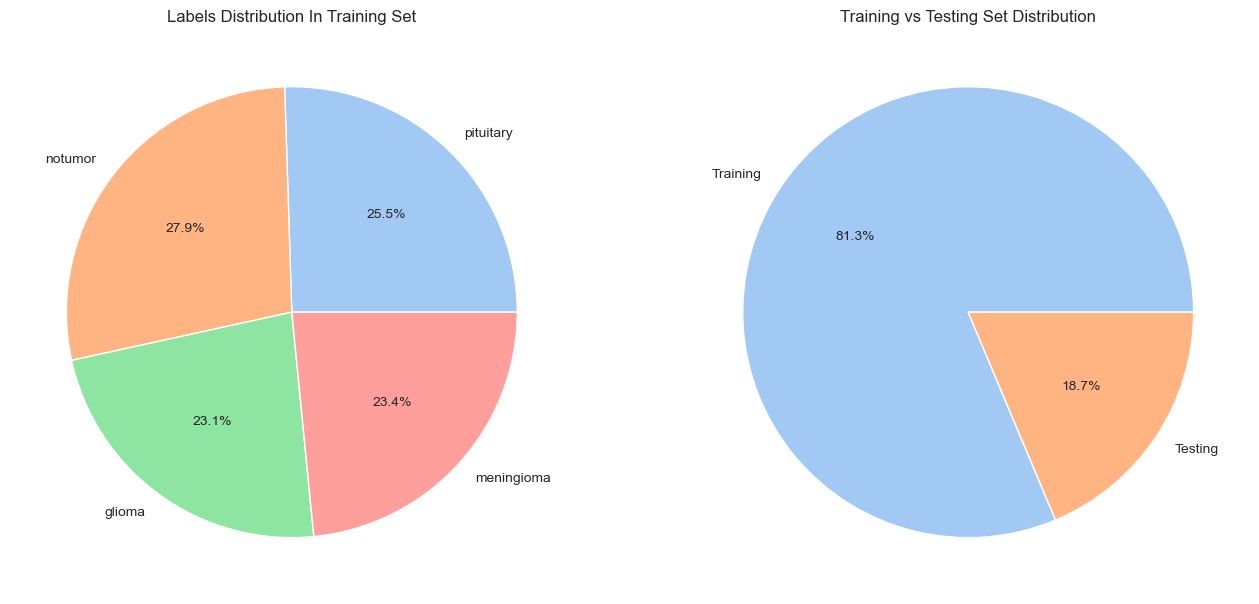

In [9]:
# visualize class distribution in train set
plt.figure(figsize=(16, 8))
colors = sns.color_palette('pastel')

plt.subplot(1, 2, 1)
plt.pie(num_images_per_label, labels=label_names, autopct='%1.1f%%', colors=colors)
plt.title('Labels Distribution In Training Set')

plt.subplot(1, 2, 2)
plt.pie([sum(num_images_per_label), sum(num_testing_images.values())], labels=['Training', 'Testing'], autopct='%1.1f%%', colors=colors)
plt.title('Training vs Testing Set Distribution')

plt.show()

**AS WE CAN SEE THAT THE DATASET IS REASONABLY BALANCED.**

### Plot samples

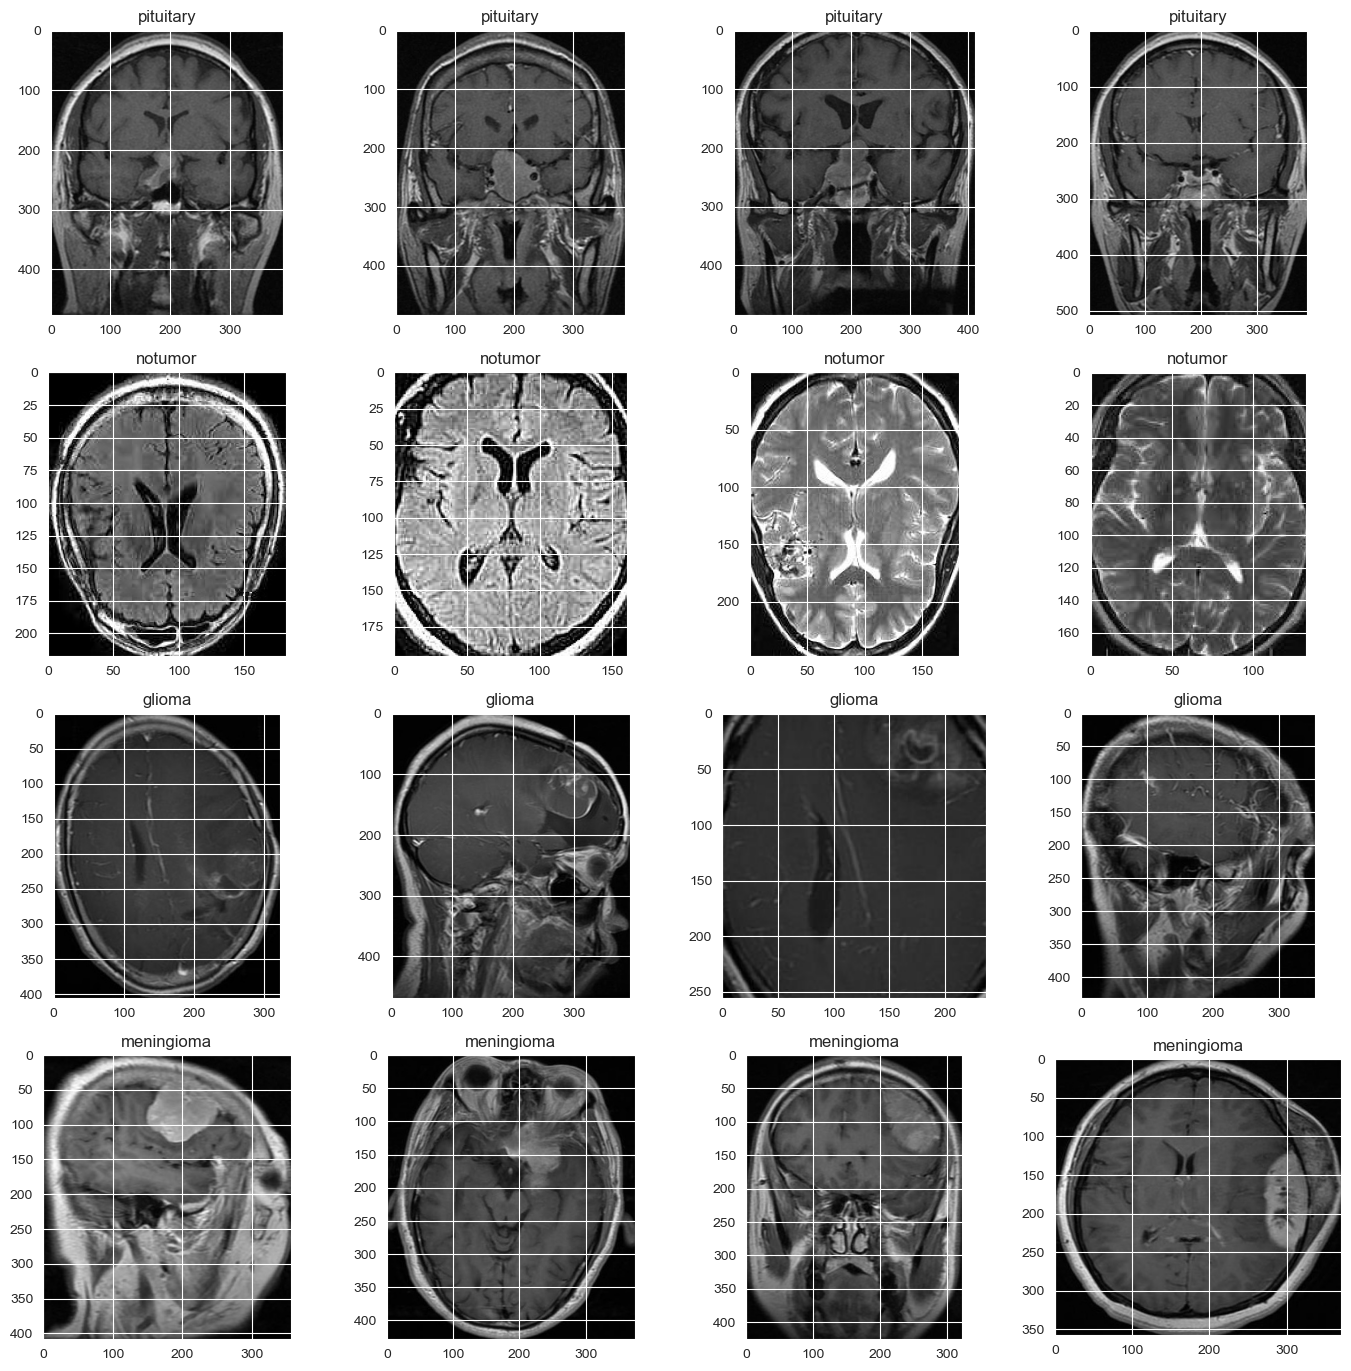

In [10]:
plt.figure(figsize = (17,17))
index = 0
for label in labels:
  path_list = files_path_dict[label][:5]
  for i in range(1, 5):
    index += 1
    plt.subplot(4, 4, index)
    plt.imshow(cv2.imread(path_list[i]))
    plt.title(label)

# Data Preprocessing

In order to load our dataset and labeling each element :

- Read the images in gray.
- Preprocess the image
    - Resize the image to (256, 256) to feed it as an input to the neural network.
    - Convert the image to grayscale as contrast and texture info is most important in grayscale rather than RGB channels.
    - Apply normalization because we want pixel values to be scaled to the range 0-1.
    - Save processed images into new directory.

### Preprocess Data

In [11]:
preprocess_data(dataset_path, processed_dataset)

Processing Testing/meningioma images: 100%|██████████| 306/306 [00:00<00:00, 534.01it/s]


### Plot sample

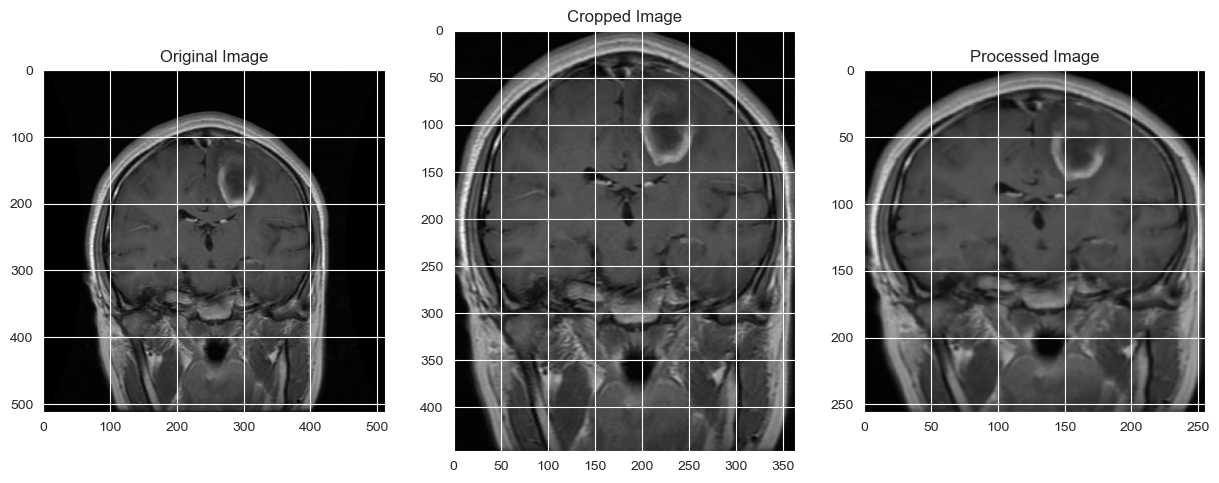

In [12]:
processed_sample = preprocess_image(cropped_sample)

plt.figure(figsize=(15, 6))

plt.subplot(1, 3, 1)
plt.imshow(sample)
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(cropped_sample)
plt.title('Cropped Image')

plt.subplot(1, 3, 3)
plt.imshow(processed_sample)
plt.title('Processed Image')

plt.show()

### Load datasets

Load preprocessed images into train & test sets,
 Reading the image in grayscale using cv2.IMREAD_GRAYSCALE flag to ensure that the image is read in a single channel format.

In [13]:
train_path = os.path.join(processed_dataset, train_dataset)
test_path = os.path.join(processed_dataset, test_dataset)
labels = ['pituitary', 'notumor', 'glioma', 'meningioma']

X, y = load_data(train_path, labels)
X_test, y_test = load_data(test_path, labels)

In [14]:
print(f'Number of samples is: {len(X)}')
print(f'X shape is: {X.shape}')
print(f'y shape is: {y.shape}')
print(f'Number of classes: {len(np.unique(y))}')

Number of samples is: 5712
X shape is: (5712, 256, 256, 3)
y shape is: (5712,)
Number of classes: 4


### Split training dataset

Split X and y into training, validation sets.

In [15]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)

In [16]:
print ("number of training samples = " + str(X_train.shape[0]))
print ("number of validation samples = " + str(X_val.shape[0]))
print ("number of test samples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val shape: " + str(X_val.shape))
print ("Y_val shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training samples = 3998
number of validation samples = 1714
number of test samples = 1311
X_train shape: (3998, 256, 256, 3)
Y_train shape: (3998,)
X_val shape: (1714, 256, 256, 3)
Y_val shape: (1714,)
X_test shape: (1311, 256, 256, 3)
Y_test shape: (1311,)


# Data Augmentation
Image augmentation artificially creates training images through different ways of processing or combination of multiple processing, such as random rotation, shifts, shear and flips, etc of each training instances.

In order to make the most of our few training samples here, we augment them via a number of random transformations, so that our model would never see twice the exact same picture. This helps prevent overfitting and helps the model generalize better.

### Build data generator

Define an image data generator to apply random transformations to the training data.

In [17]:
# ImageDataGenerator transforms each image in the batch by a series of random translations, rotations, etc.
data_generator = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True)

### Plot sample

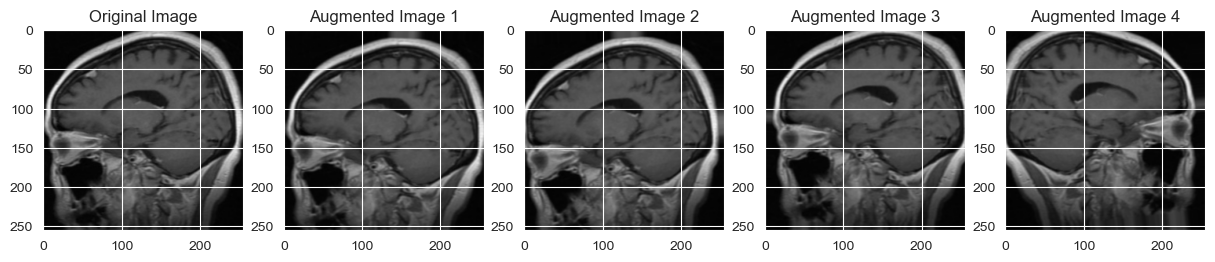

In [18]:
# Reshape image to (1, height, width, channel)
img = np.reshape(X_train[0], (1,) + X_train[0].shape)


# Generate augmented images
augmented_image = data_generator.flow(img)

# Plot original and augmented images
fig, axs = plt.subplots(1, 5, figsize=(15, 3))
axs[0].imshow(X_train[0])
axs[0].set_title("Original Image")
for i in range(1, 5):
    axs[i].imshow(augmented_image.next()[0].astype('int'))
    axs[i].set_title("Augmented Image {}".format(i))
plt.show()

### Generate augmented data

Generate augmented images data and save it to new location.

In [19]:
# Add dimension (channel) grayscale to X_train to make it compatible with Keras' input format for 2D grayscale images

# Compute the number of batches based on the total number of training samples
total_samples = len(X_train)
#num_batches = ceil(total_samples / batch_size)
num_batches = 10

# Initialize empty lists for X and y
X_train_augmented = []
y_train_augmented = []

X_train_augmented_batches = []
y_train_augmented_batches = []

progress_bar = tqdm(total=num_batches, desc=f'Augmenting images', dynamic_ncols=True)
for i in range(num_batches): # generating all batches may take forever
    # Generate augmented data on-the-fly in batches.
    batch = data_generator.flow(X_train, y_train, batch_size=32, shuffle=True)
    X_batch, y_batch = batch.next()

    X_train_augmented.append(X_batch)
    y_train_augmented.append(y_batch)

    progress_bar.update(1)

# Concatenate the augmented images and labels
X_train_augmented_batches = np.concatenate(X_train_augmented, axis=0)
y_train_augmented_batches = np.concatenate(y_train_augmented, axis=0)


# Reshape the augmented data to (num_of_sample, number_patches, 256, 256, 1)
#X_train_augmented_batches = np.expand_dims(X_train_augmented_batches, axis=-1)
X_train_augmented_batches = np.reshape(X_train_augmented_batches, (-1, num_batches, 256, 256, 3))

progress_bar.close()

Augmenting images: 100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


In [20]:
print(X_train_augmented_batches.shape)

(32, 10, 256, 256, 3)


### Save the augmented data

In [21]:
# Save the original data and generate augmented images
save_augmented_images(data=[X_train_augmented_batches, y_train_augmented_batches], destination_path=augmented_dataset, labels=labels)

print('{} batch with total {} augmented image generated successfully!'.format(num_batches, batch_size * num_batches))

Saving augmented images: 100%|██████████| 32/32 [00:00<00:00, 157.09it/s]

10 batch with total 320 augmented image generated successfully!


# Modeling

#### Load Training data

In [22]:
X_train_augmented, y_train_augmented = load_data(augmented_dataset, labels)
IMG_SHAPE = (img_size, img_size, 3)

print(f'Number of samples is: {len(X_train_augmented)}')
print(f'X shape is: {X_train_augmented.shape}')
print(f'y shape is: {y_train_augmented.shape}')

print(f'Number of classes: {len(np.unique(y_train_augmented))}')

Number of samples is: 320
X shape is: (320, 256, 256, 3)
y shape is: (320,)
Number of classes: 4


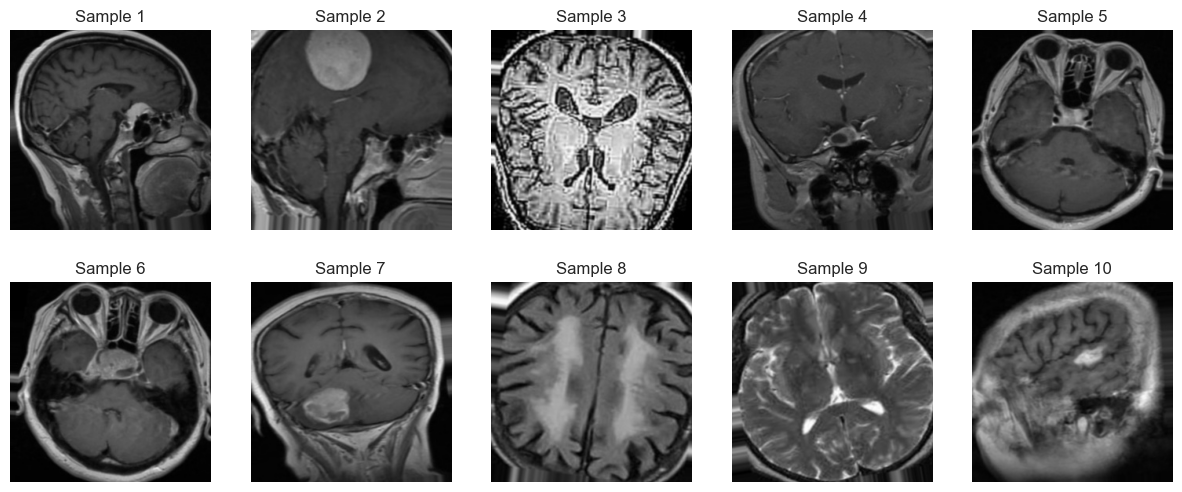

In [23]:
# display 10 augmented images from X_train
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))

for i in range(10):
    img = X_train_augmented[i]
    row = i // 5
    col = i % 5
    ax[row, col].imshow(img)
    ax[row, col].set_title(f"Sample {i+1}")
    ax[row, col].axis("off")

plt.show()

### Model Callbacks

Here we're setting up the necessary tools for optimizing the model's performance during training and evaluation.

- `TensorBoard` A tool provided by TensorFlow allows can help understand the behavior of your model, identify potential problems, and optimize training process.

- `ModelCheckpoint` A callback provided by Keras allows to save the weights of your model during training and to keep track of the best-performing version of your model.

In [24]:
# tensorboard
log_file_name = f'brain_tumor_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')

In [25]:
# checkpoint
# unique file name that will include the epoch and the validation (development) accuracy
filepath="cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}"
# save the model with the best validation (development) accuracy till now
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'))

## Baseline model

In this step we're going to define baseline model to provide a point of reference for the performance of other more complex models we're going to implement using learning transfer technique, and as well helps to identify if a model is over-fitting or under-fitting the data.

![basic-arch](assets/basic-model-arch.png)

### Network Architecture

A baseline model usually build as simple Convolutional Neural Network (CNN) with a few layers that are commonly used for image processing tasks.

A basic CNN architecture for image classification usually consists of convolutional layers, followed by pooling layers, then one or more fully connected layers (also known as dense layers), and a final output layer.

__Brain Tumor baseline model architecture__

So we decide to build a simple Convolutional Neural Network (CNN) with a few convolutional layers and max pooling layers, followed by a fully connected layer with a sigmoid activation function.

**Our model here designed to take in images of size (256, 256, 1) and output a multi-class classification indicating the type of brain tumor.**

- The model architecture consists of:
    - A convolutional layer with 32 filters of size (7, 7), with stride 1 and no padding.
    - A batch normalization layer to normalize the activations of the previous layer.
    - A ReLU activation layer to introduce non-linearity.
    - A max pooling layer with a pool size of (4, 4), which reduces the size of the feature maps by a factor of 4.
    - Another max pooling layer with a pool size of (4, 4), further reducing the size of the feature maps.
    - A flatten layer to convert the 2D feature maps into a 1D feature vector.
    - A fully connected layer with a sigmoid activation function to generate the final binary classification.

This is a good starting point for a baseline model, and we can explore more advanced architectures or techniques such as `transfer learning` to further improve performance.

We can enhance this baseline model by **adding more convolutional layers, increasing the number of filters in each layer, adding more fully connected layers, and increasing the size of the input images**. However, we need to be careful not to overcomplicate the model, as this can lead to over-fitting and poor performance on new data.

### Model Declaration

In [26]:
def build_sequential_model(input_shape, num_classes):
    """
    Arguments:
        input_shape: A tuple representing the shape of the input of the model. shape=(image_width, image_height, #_channels)
        num_classes: An integer representing the number of classes to predict.
    Returns:
        model: A Model object.
    """
    model = Sequential()

    # Add layers to the model
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [27]:
baseline_model = build_sequential_model(IMG_SHAPE, len(labels))
baseline_model.summary()

Metal device set to: Apple M1 Pro
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxP

### Model Compiling

In this for configuring and compiling our model we are using:
- `Adam` optimizer to stochastic gradient descent, to optimize the model's parameters.
- `sparse_categorical_crossentropy` loss function to compute the difference between the predicted and true class labels.
And We're specifying that we want to evaluate the `accuracy` of the model during training.

In [28]:
baseline_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### Model Training

In [ ]:
start_time = time.time()
baseline_model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])
end_time = time.time()
execution_time = (end_time - start_time)

print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/10


2023-04-18 15:58:49.744903: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


125/125 [==============================] - ETA: 0s - loss: 57.0539 - accuracy: 0.5863

INFO:tensorflow:Assets written to: models/cnn-parameters-improvement-01-0.75.model/assets


INFO:tensorflow:Assets written to: models/cnn-parameters-improvement-01-0.75.model/assets


125/125 [==============================] - 24s 182ms/step - loss: 57.0539 - accuracy: 0.5863 - val_loss: 0.7364 - val_accuracy: 0.7462
Epoch 2/10
125/125 [==============================] - ETA: 0s - loss: 0.5208 - accuracy: 0.8087

INFO:tensorflow:Assets written to: models/cnn-parameters-improvement-02-0.73.model/assets


INFO:tensorflow:Assets written to: models/cnn-parameters-improvement-02-0.73.model/assets


125/125 [==============================] - 21s 169ms/step - loss: 0.5208 - accuracy: 0.8087 - val_loss: 0.7436 - val_accuracy: 0.7281
Epoch 3/10
125/125 [==============================] - ETA: 0s - loss: 0.2698 - accuracy: 0.9005

INFO:tensorflow:Assets written to: models/cnn-parameters-improvement-03-0.83.model/assets


INFO:tensorflow:Assets written to: models/cnn-parameters-improvement-03-0.83.model/assets


125/125 [==============================] - 22s 172ms/step - loss: 0.2698 - accuracy: 0.9005 - val_loss: 0.5982 - val_accuracy: 0.8337
Epoch 4/10
125/125 [==============================] - ETA: 0s - loss: 0.0197 - accuracy: 0.9942

INFO:tensorflow:Assets written to: models/cnn-parameters-improvement-08-0.82.model/assets


INFO:tensorflow:Assets written to: models/cnn-parameters-improvement-08-0.82.model/assets


125/125 [==============================] - 21s 170ms/step - loss: 0.0197 - accuracy: 0.9942 - val_loss: 0.9432 - val_accuracy: 0.8221
Epoch 9/10
125/125 [==============================] - ETA: 0s - loss: 0.0598 - accuracy: 0.9810

INFO:tensorflow:Assets written to: models/cnn-parameters-improvement-09-0.74.model/assets


INFO:tensorflow:Assets written to: models/cnn-parameters-improvement-09-0.74.model/assets


125/125 [==============================] - 21s 170ms/step - loss: 0.0598 - accuracy: 0.9810 - val_loss: 2.0114 - val_accuracy: 0.7415
Epoch 10/10
125/125 [==============================] - ETA: 0s - loss: 0.1127 - accuracy: 0.9640

INFO:tensorflow:Assets written to: models/cnn-parameters-improvement-10-0.80.model/assets


INFO:tensorflow:Assets written to: models/cnn-parameters-improvement-10-0.80.model/assets


125/125 [==============================] - 21s 167ms/step - loss: 0.1127 - accuracy: 0.9640 - val_loss: 0.9615 - val_accuracy: 0.7964
Elapsed time: 0:3:35.7


### Model Evaluation

#### Plotting

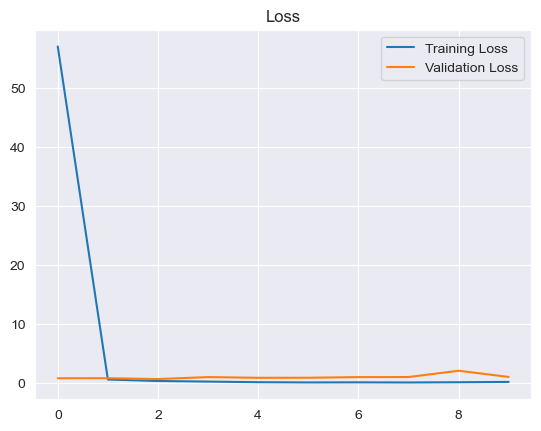

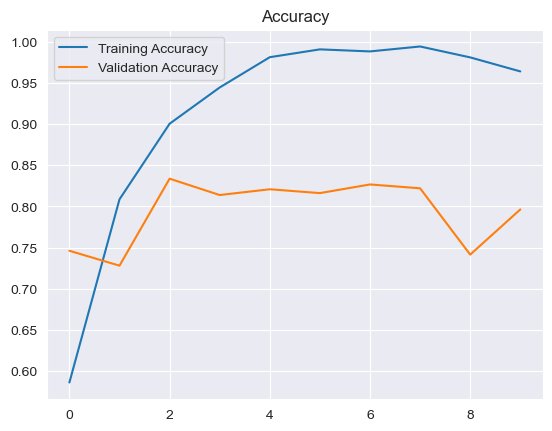

In [30]:
history = baseline_model.history

plot_metrics(history.history)

#### Best Model

In [31]:
best_baseline_model = load_model(filepath=f'{models_path}/cnn-parameters-improvement-08-0.82.model')
best_baseline_model.metrics_names

['loss', 'accuracy']

#### Model Evaluation

In [32]:
baseline_model.evaluate(x=X_val, y=y_val)

54/54 [==============================] - 3s 50ms/step - loss: 0.9615 - accuracy: 0.7964


[0.9615221619606018, 0.7963827252388]

In [33]:
best_baseline_model.evaluate(x=X_val, y=y_val)

54/54 [==============================] - 3s 49ms/step - loss: 0.9432 - accuracy: 0.8221


[0.9432172775268555, 0.8220536708831787]

In [34]:
y_val_pred = best_baseline_model.predict(X_val)
y_val_pred_arg = y_val_pred.argmax(axis=1)

54/54 [==============================] - 2s 43ms/step


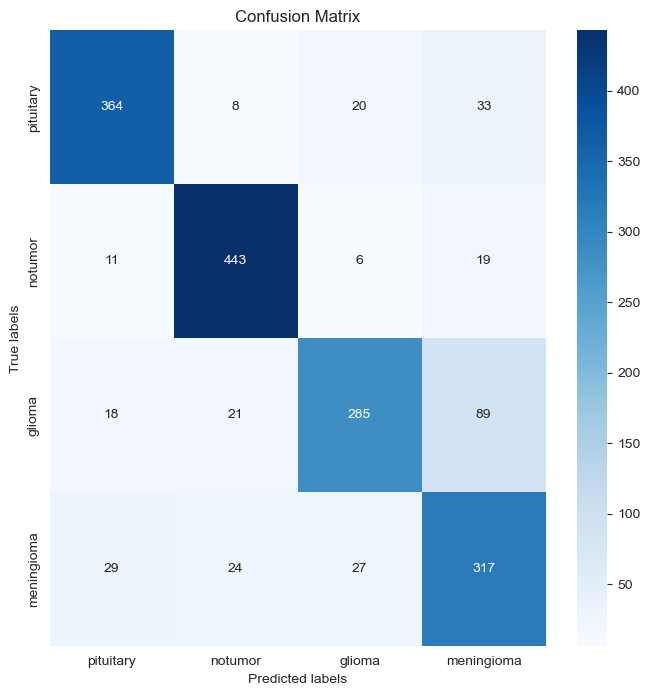

Confusion matrix
None
Classification Report
              precision    recall  f1-score   support

   pituitary       0.86      0.86      0.86       425
     notumor       0.89      0.92      0.91       479
      glioma       0.84      0.69      0.76       413
  meningioma       0.69      0.80      0.74       397

    accuracy                           0.82      1714
   macro avg       0.82      0.82      0.82      1714
weighted avg       0.83      0.82      0.82      1714

None


In [36]:
co_mat = confusion_matrix(y_val, y_val_pred_arg, labels=labels)

print(co_mat)
print(classification_report(y_val, y_val_pred_arg, labels))

### Final Insights

The results of the baseline model were acceptable, but we decided to explore other combinations to improve the results.
In the first instance, applying another 2-dimensional convolutional operation with 128 filters. This approach improves the accuracy of the model.
After this, we applied a Dropout layer with a rate set to 0.5 or 50%, which means that half of the input units will be randomly set to 0 during each training iteration. (I don’t know if this method is going to improve the accuracy because in the other jupyter notebook it decreased it).
The same Padding on the three 2-dimensional convolutional layers was performed. In that way, we ensure that the spatial dimensions of the input and output tensors are preserved during convolutional operations, and prevent the loss of important spatial information in the network.

## Learning Transfer

Since our dataset used is small, one method of addressing this lack of data in a given domain is to leverage data from a similar domain, a technique known as Transfer Learning (TL).

TL means using what is learned from one task and applying that to another task without learning from scratch.

![learning-transfer-concepts](assets/learning-transfer.png)

### VGG16

#### Network Architecture

VGGNet consists of 16 convolutional layers and is very appealing because of its very uniform architecture. Similar to AlexNet, only 3x3 convolutions, but lots of filters.

 It makes the improvement over AlexNet by replacing large kernel-sized filters (11 and 5 in the first and second convolutional layer, respectively) with multiple 3×3 kernel-sized filters one after another.


![unnet-arch](assets/vgg16.png)

#### Model Declaration

In [37]:
# VGG16
vgg = VGG16(input_shape=IMG_SHAPE, weights='imagenet', include_top=False)

for layer in vgg.layers:
    layer.trainable = False

x = Flatten()(vgg.output)
x = Dense(units = 512, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dropout(rate=0.5)(x)
x = Dense(units = 5, activation='softmax')(x)
vgg16_model = Model(inputs=vgg.input, outputs=x)

#### Model Compiling

In [38]:
vgg16_model.compile(optimizer = 'adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#### Model Training

In [39]:
vgg16_model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

Epoch 1/10
125/125 [==============================] - ETA: 0s - loss: 0.5111 - accuracy: 0.8514

INFO:tensorflow:Assets written to: models/cnn-parameters-improvement-01-0.91.model/assets


INFO:tensorflow:Assets written to: models/cnn-parameters-improvement-01-0.91.model/assets


125/125 [==============================] - 65s 517ms/step - loss: 0.5111 - accuracy: 0.8514 - val_loss: 0.2798 - val_accuracy: 0.9137
Epoch 2/10
125/125 [==============================] - ETA: 0s - loss: 0.1144 - accuracy: 0.9620

INFO:tensorflow:Assets written to: models/cnn-parameters-improvement-02-0.92.model/assets


INFO:tensorflow:Assets written to: models/cnn-parameters-improvement-02-0.92.model/assets


125/125 [==============================] - 62s 498ms/step - loss: 0.1144 - accuracy: 0.9620 - val_loss: 0.2392 - val_accuracy: 0.9189
Epoch 3/10
125/125 [==============================] - ETA: 0s - loss: 0.0569 - accuracy: 0.9812

INFO:tensorflow:Assets written to: models/cnn-parameters-improvement-03-0.93.model/assets


INFO:tensorflow:Assets written to: models/cnn-parameters-improvement-03-0.93.model/assets


125/125 [==============================] - 62s 497ms/step - loss: 0.0569 - accuracy: 0.9812 - val_loss: 0.1969 - val_accuracy: 0.9317
Epoch 4/10
125/125 [==============================] - ETA: 0s - loss: 0.0306 - accuracy: 0.9912

INFO:tensorflow:Assets written to: models/cnn-parameters-improvement-04-0.94.model/assets


INFO:tensorflow:Assets written to: models/cnn-parameters-improvement-04-0.94.model/assets


125/125 [==============================] - 62s 495ms/step - loss: 0.0306 - accuracy: 0.9912 - val_loss: 0.1777 - val_accuracy: 0.9376
Epoch 5/10
125/125 [==============================] - ETA: 0s - loss: 0.0273 - accuracy: 0.9925

INFO:tensorflow:Assets written to: models/cnn-parameters-improvement-05-0.94.model/assets


INFO:tensorflow:Assets written to: models/cnn-parameters-improvement-05-0.94.model/assets


125/125 [==============================] - 62s 496ms/step - loss: 0.0273 - accuracy: 0.9925 - val_loss: 0.1711 - val_accuracy: 0.9417
Epoch 6/10
125/125 [==============================] - ETA: 0s - loss: 0.0240 - accuracy: 0.9915

INFO:tensorflow:Assets written to: models/cnn-parameters-improvement-06-0.93.model/assets


INFO:tensorflow:Assets written to: models/cnn-parameters-improvement-06-0.93.model/assets


125/125 [==============================] - 64s 513ms/step - loss: 0.0240 - accuracy: 0.9915 - val_loss: 0.2250 - val_accuracy: 0.9347
Epoch 7/10
125/125 [==============================] - ETA: 0s - loss: 0.0199 - accuracy: 0.9937

INFO:tensorflow:Assets written to: models/cnn-parameters-improvement-07-0.94.model/assets


INFO:tensorflow:Assets written to: models/cnn-parameters-improvement-07-0.94.model/assets


125/125 [==============================] - 63s 503ms/step - loss: 0.0199 - accuracy: 0.9937 - val_loss: 0.2147 - val_accuracy: 0.9411
Epoch 8/10
125/125 [==============================] - ETA: 0s - loss: 0.0215 - accuracy: 0.9930

INFO:tensorflow:Assets written to: models/cnn-parameters-improvement-08-0.93.model/assets


INFO:tensorflow:Assets written to: models/cnn-parameters-improvement-08-0.93.model/assets


125/125 [==============================] - 63s 503ms/step - loss: 0.0215 - accuracy: 0.9930 - val_loss: 0.2882 - val_accuracy: 0.9294
Epoch 9/10
125/125 [==============================] - ETA: 0s - loss: 0.0266 - accuracy: 0.9917

INFO:tensorflow:Assets written to: models/cnn-parameters-improvement-09-0.94.model/assets


INFO:tensorflow:Assets written to: models/cnn-parameters-improvement-09-0.94.model/assets


125/125 [==============================] - 64s 511ms/step - loss: 0.0266 - accuracy: 0.9917 - val_loss: 0.2103 - val_accuracy: 0.9446
Epoch 10/10
125/125 [==============================] - ETA: 0s - loss: 0.0105 - accuracy: 0.9977

INFO:tensorflow:Assets written to: models/cnn-parameters-improvement-10-0.94.model/assets


INFO:tensorflow:Assets written to: models/cnn-parameters-improvement-10-0.94.model/assets


125/125 [==============================] - 64s 513ms/step - loss: 0.0105 - accuracy: 0.9977 - val_loss: 0.2286 - val_accuracy: 0.9376


#### Plot Loss & Accuracy

#### Model Evaluation

In [40]:
vgg16_model.evaluate(x=X_val, y=y_val)

54/54 [==============================] - 19s 339ms/step - loss: 0.2286 - accuracy: 0.9376


[0.22859953343868256, 0.9375729560852051]

54/54 [==============================] - 19s 341ms/step


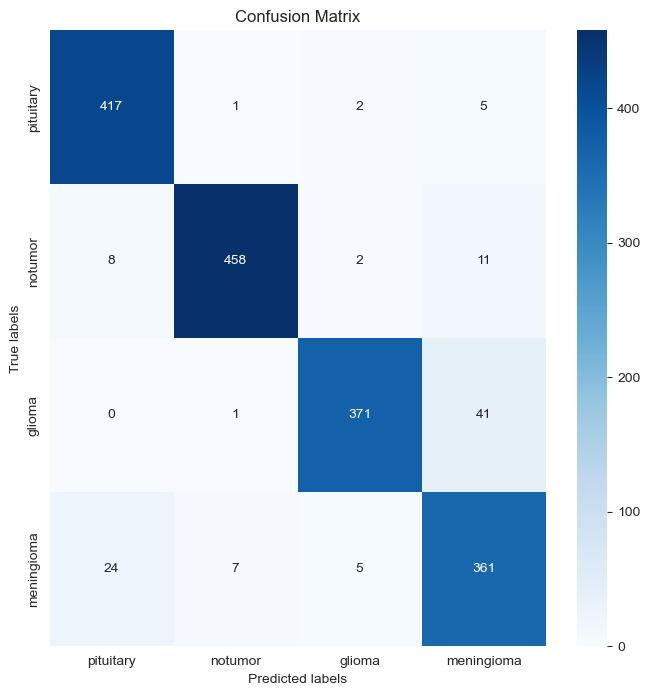

Confusion matrix
None
Classification Report
              precision    recall  f1-score   support

   pituitary       0.93      0.98      0.95       425
     notumor       0.98      0.96      0.97       479
      glioma       0.98      0.90      0.94       413
  meningioma       0.86      0.91      0.89       397

    accuracy                           0.94      1714
   macro avg       0.94      0.94      0.94      1714
weighted avg       0.94      0.94      0.94      1714

None


In [41]:
y_val_pred = vgg16_model.predict(X_val)
y_val_pred_arg = y_val_pred.argmax(axis=1)
co_mat = confusion_matrix(y_val, y_val_pred_arg, labels)

print(co_mat)
print(classification_report(y_val, y_val_pred_arg, labels))

### EfficientNet

EfficientNet is a convolutional neural network architecture and scaling method that uniformly scales all dimensions of a CNN such as depth/width/resolution using a compound coefficient.

We are going to initialize EfficientNetB1 model and use weight=‘imagenet’.

[ImageNet](https://www.image-net.org/) is a large visual database designed for use in visual object recognition software research.

#### Network Architecture

To Add our own layers on the top of EfficientNetB1:

- `GlobalAveragePooling2D` to replace fully connected layers. It takes the average of each feature map and feed the resulting vector directly into the softmax layer.
- `Dropout` to prevent overfitting by reducing the number of neurons.
- `Dense` as output layer with activation softmax since this is a multi-class classification problem.

![efficientnet-arch](assets/efficientnet.png)

EfficientNet model has 4 component:
- Stem layer
- final layer
- Sub-blocks: each block has sub-blocks.
- Modules: each sub-blocks has modules.

![efficient-moules](assets/efficient-moules.png)

#### Model Declaration

In [42]:
# build the model
effnet = EfficientNetB1(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)

effnet_model = effnet.output
effnet_model = GlobalAveragePooling2D()(effnet_model)
effnet_model = Dropout(0.5)(effnet_model)
effnet_model = Dense(4, activation='softmax')(effnet_model)
effnet_model = Model(inputs=effnet.input, outputs=effnet_model)

effnet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 256, 256, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 256, 256, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 256, 256, 3)  0           ['normalization[0][0]']    

#### Model Compiling

In [43]:
effnet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#### Model Training

In [46]:
#train the model
effnet_model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val), verbose=1)

Epoch 1/10
125/125 [==============================] - 118s 892ms/step - loss: 0.1013 - accuracy: 0.9657 - val_loss: 0.1811 - val_accuracy: 0.9382
Epoch 2/10
125/125 [==============================] - 115s 916ms/step - loss: 0.0857 - accuracy: 0.9702 - val_loss: 0.1808 - val_accuracy: 0.9370
Epoch 3/10
125/125 [==============================] - 110s 877ms/step - loss: 0.0949 - accuracy: 0.9672 - val_loss: 0.1113 - val_accuracy: 0.9609
Epoch 4/10
125/125 [==============================] - 114s 897ms/step - loss: 0.0662 - accuracy: 0.9760 - val_loss: 0.0722 - val_accuracy: 0.9772
Epoch 5/10
125/125 [==============================] - 116s 928ms/step - loss: 0.0526 - accuracy: 0.9832 - val_loss: 0.1363 - val_accuracy: 0.9580
Epoch 6/10
125/125 [==============================] - 111s 884ms/step - loss: 0.0693 - accuracy: 0.9780 - val_loss: 0.1136 - val_accuracy: 0.9691
Epoch 7/10
125/125 [==============================] - 106s 846ms/step - loss: 0.0470 - accuracy: 0.9842 - val_loss: 0.1045 -

#### Plot Loss & Accuracy

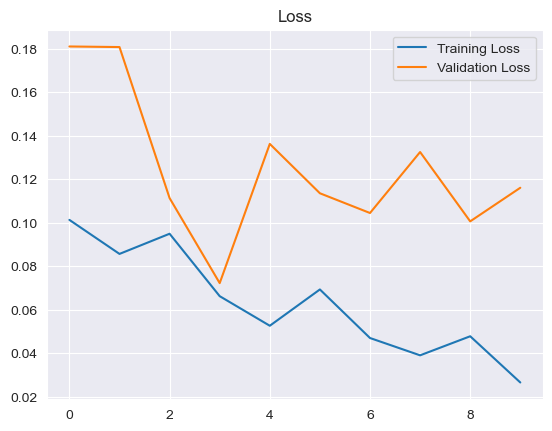

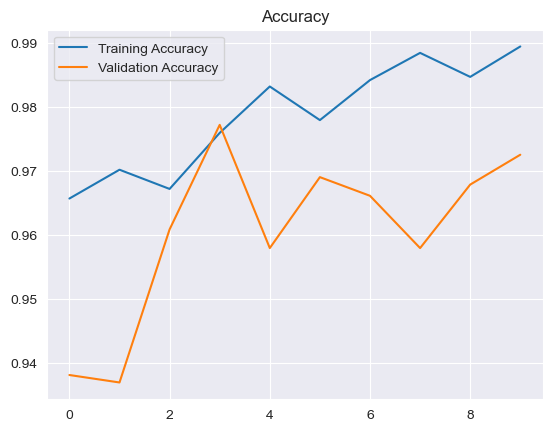

In [47]:
history = effnet_model.history
plot_metrics(history.history)

#### Model Evaluation

In [48]:
effnet_model.evaluate(x=X_val, y=y_val)

54/54 [==============================] - 9s 148ms/step - loss: 0.1161 - accuracy: 0.9726


[0.1160905733704567, 0.972578763961792]

54/54 [==============================] - 20s 246ms/step


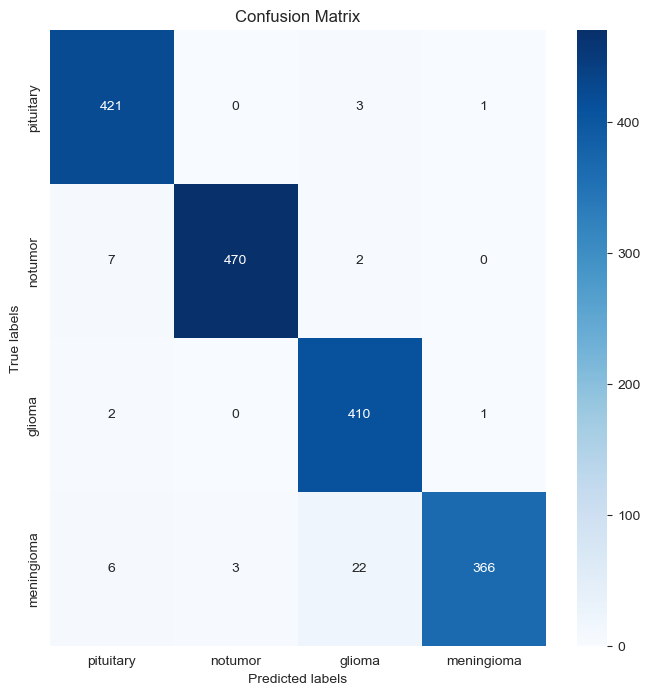

Confusion matrix
None
Classification Report
              precision    recall  f1-score   support

   pituitary       0.97      0.99      0.98       425
     notumor       0.99      0.98      0.99       479
      glioma       0.94      0.99      0.96       413
  meningioma       0.99      0.92      0.96       397

    accuracy                           0.97      1714
   macro avg       0.97      0.97      0.97      1714
weighted avg       0.97      0.97      0.97      1714

None


In [49]:
y_val_pred = effnet_model.predict(X_val)
y_val_pred_arg = y_val_pred.argmax(axis=1)
co_mat = confusion_matrix(y_val, y_val_pred_arg, labels)

print(co_mat)
print(classification_report(y_val, y_val_pred_arg, labels))

## Results Interpretation

Let's experiment with the best model (the one with the best validation accuracy):

**Concretely, our `EfficientNetB1` model with validation accuracy ~97% Yeaaah !!**

### Best model

Let's for last time evaluate best model on Testing dataset

In [54]:
loss_test, acc_test = effnet_model.evaluate(x=X_test, y=y_test)

41/41 [==============================] - 9s 204ms/step - loss: 0.0559 - accuracy: 0.9825


### Best model Accuracy

In [55]:
print (f"Test Loss = {loss_test}")
print (f"Test Accuracy = {acc_test}")

Test Loss = 0.05589069798588753
Test Accuracy = 0.9824561476707458


### Best model F1-Score

On testing dataset

In [56]:
y_test_prob = np.argmax(effnet_model.predict(X_test), axis=1)

f1_score_test = compute_f1_score(y_test, y_test_prob)
print(f"F1 score on Testing: {f1_score_test}")

41/41 [==============================] - 8s 203ms/step
F1 score on Testing: 0.9811267797511498


## Conclusion

Now, the model detects brain tumor with:

- `98.0%` accuracy on the test set.
- `0.97` f1 score on the test set.

These results are very good considering that the data is balanced.


Performance Table:

| Validation set | Test set |
|----------------|----------|
| Accuracy       | 96%      | 98% |
| F1 score       | 0.96     | 0.97 |

Hooray!